## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [125]:
#from google.colab import drive
#drive.mount('/content/drive')

In [126]:
# Make sure to change path if you put the zip elsewhere
#!unzip drive/MyDrive/chest_xray.zip

## Create dataset from directory

In [127]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128
IMG_PATH = "../../data/PW4/"

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path(f'{IMG_PATH}chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path(f'{IMG_PATH}chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path(f'{IMG_PATH}chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


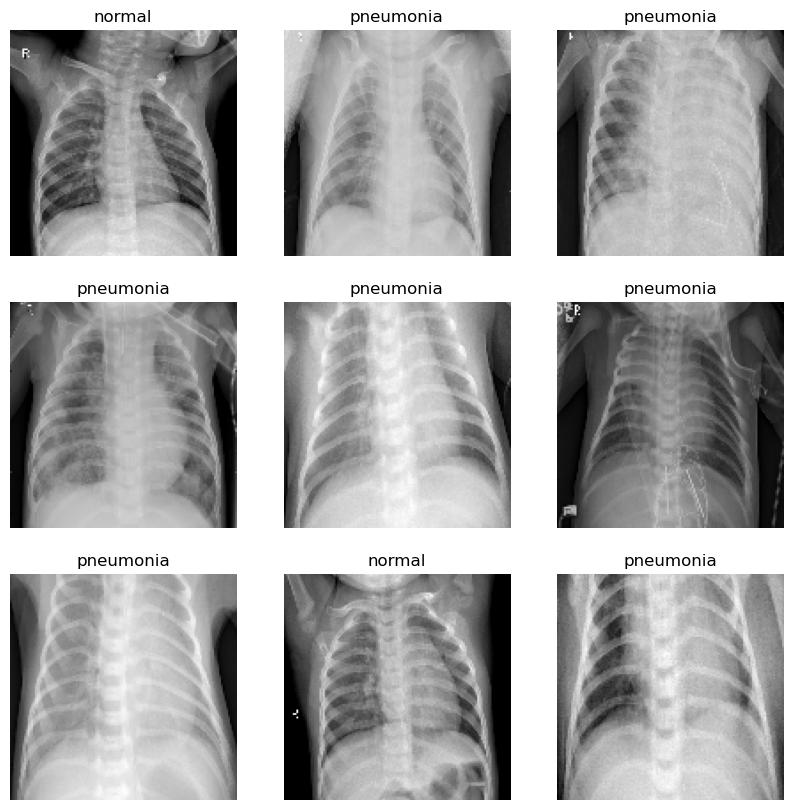

In [128]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [129]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [130]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

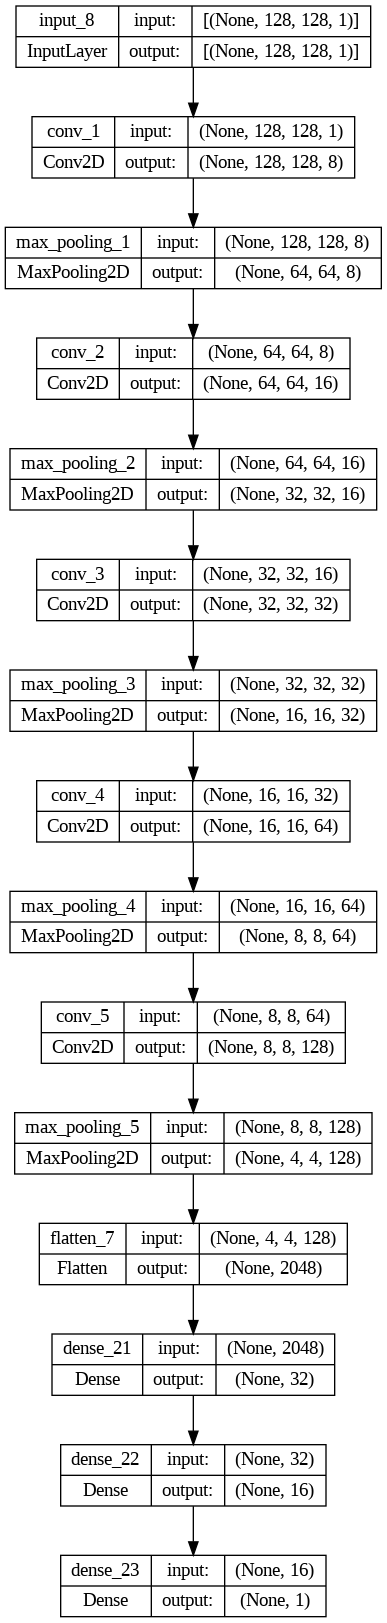

In [131]:
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

# Define CNN model
input_8 = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

# note: use convolutions with relu and kernel size of 3.

conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input_8)
max_pooling_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_1')(conv_1)

conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_2')(conv_2)

conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_3')(conv_3)

conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_4')(conv_4)

conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_pooling_4)
max_pooling_5 = MaxPooling2D(pool_size=(2, 2), name='max_pooling_5')(conv_5)


flatten_7 = Flatten(name='flatten_7')(max_pooling_5)

dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)


cnn_output = layers.Dense(1, activation='sigmoid', name='dense_23')(dense_22)
cnn = Model(inputs=input_8, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [132]:
cnn.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_8 (InputLayer)            │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_4 (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_5 (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,353 (642.00 KB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
#!pip install pydot

In [134]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
#plot_model(cnn, show_shapes=True, show_layer_names=True)

In [135]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10


82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5899 - loss: 0.7321 - val_accuracy: 0.8125 - val_loss: 0.5368
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9207 - loss: 0.2143 - val_accuracy: 0.8750 - val_loss: 0.1806
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9432 - loss: 0.1459 - val_accuracy: 0.8750 - val_loss: 0.2178
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9702 - loss: 0.0818 - val_accuracy: 0.9375 - val_loss: 0.1292
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9746 - loss: 0.0691 - val_accuracy: 1.0000 - val_loss: 0.0700
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9830 - loss: 0.0464 - val_accuracy: 1.0000 - val_loss: 0.0221
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9890 - loss: 0.0362 - val_accuracy: 0.8750 - val_loss: 0.2576
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9900 - loss: 0.0296 - val_accuracy: 0.9375 - val_loss: 0.

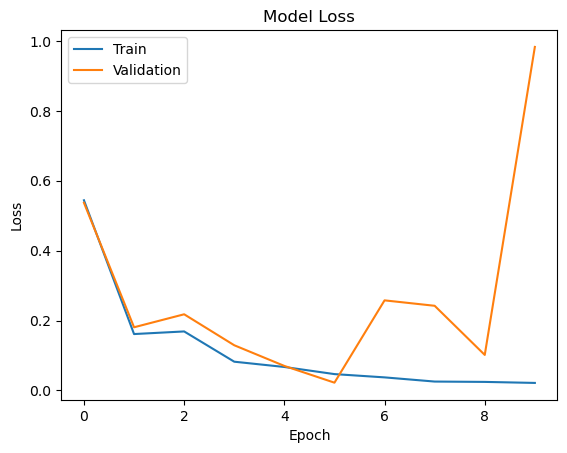

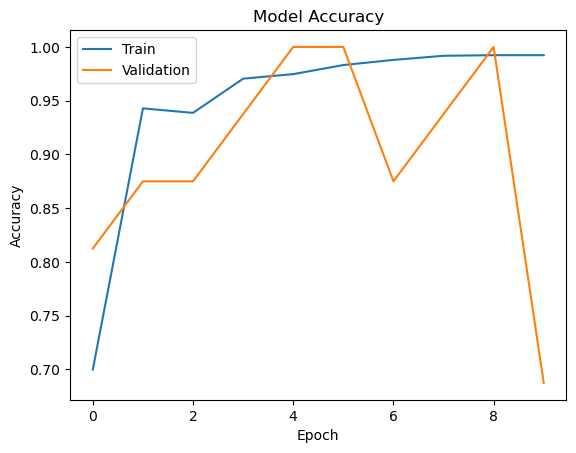

In [136]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Text(50.72222222222221, 0.5, 'True labels')

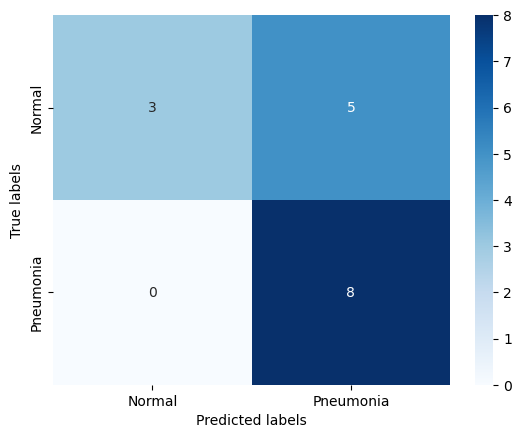

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)


val_predictions = cnn.predict(val_images).squeeze().round().astype(int)
val_confusion_matrix = confusion_matrix(val_labels, val_predictions)

sns.heatmap(val_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Text(50.72222222222221, 0.5, 'True labels')

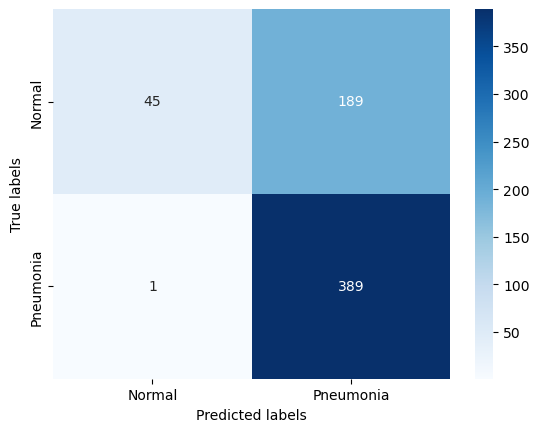

In [138]:
#Test set
val_images_test = []
val_labels_test = []

for img, label in test_ds:
  val_images_test.append(img)
  val_labels_test.append(label)

val_images_test = np.vstack(val_images_test)
val_labels_test = np.vstack(val_labels_test).squeeze().astype(int)


val_test_prediction = cnn.predict(val_images_test).squeeze().round().astype(int)
val_test_confusion_matrix = confusion_matrix(val_labels_test, val_test_prediction)

sns.heatmap(val_test_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

In [139]:
#F1 score
from sklearn.metrics import f1_score

f1_score(val_labels_test, val_test_prediction)



0.8037190082644629